In [2]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
result_dir = '../../results/hospital-billing/'

In [69]:
store_fp = os.path.join(result_dir, 'hospital-billing_2013-2016_min-length-10_hmmconf.h5')
store = pd.HDFStore(store_fp)
k = 5
test_dfs = []

for fold_no in range(k):
    test_df_name = 'test_hmmconf_feature_fold_{}_df'.format(fold_no)
    test_df = store[test_df_name]
    test_df['fold_no'] = fold_no
    test_dfs.append(test_df)

store.close()

test_df = pd.concat(test_dfs)
test_df = test_df.sort_values(['caseid', 'case_prefix']).reset_index(drop=True)
test_df['activity'] = test_df['case_prefix'].str.split(';').str[-1]
state_cols = [
    'i_1', 'p0_1', 'o_1', 
    'p1_1', 'p2_1', 'p3_1',
    'p4_1', 'p5_1', 'p6_1'
]
test_df['mode_state'] = test_df[state_cols].apply(lambda row: row.idxmax(), axis=1)

In [71]:
test_df.head()

,caseid,case_prefix,i_1,p0_1,o_1,p1_1,p2_1,p3_1,p4_1,p5_1,p6_1,emitconf,stateconf,finalconf,injected_distance,completeness,fold_no,activity
0,0,NEW,0.0,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,1.0,-1.0,1.0,0,1.0,1,NEW
1,0,NEW;FIN,-inf,-0.851925,-inf,-inf,-inf,-inf,-inf,-inf,-inf,1.0,1.0,1.0,0,1.0,1,FIN
2,0,NEW;FIN;RELEASE,-inf,-inf,-inf,-0.851925,-inf,-inf,-inf,-inf,-inf,1.0,1.0,1.0,0,1.0,1,RELEASE
3,0,NEW;FIN;RELEASE;CODE OK,-inf,-inf,-inf,-inf,-0.989126,-inf,-inf,-inf,-inf,1.0,1.0,1.0,0,1.0,1,CODE OK
4,0,NEW;FIN;RELEASE;CODE OK;REOPEN,-inf,-inf,-inf,-inf,-inf,-1.543161,-inf,-inf,-inf,1.0,1.0,1.0,0,1.0,1,REOPEN


### Compute average conformance value

#### Grouped by cases and fold no

In [72]:
grouped = test_df.groupby(['fold_no', 'caseid']).agg({
    'finalconf': np.mean
}).reset_index()
grouped.groupby('fold_no').agg({
    'finalconf': [np.mean, np.std]
})

finalconf          
             mean       std
fold_no                    
0        0.935759  0.096916
1        0.951646  0.080083
2        0.955095  0.076660
3        0.873885  0.146620
4        0.948494  0.082139

In [73]:
grouped = test_df.groupby(['fold_no', 'caseid']).tail(n=1)

# filter out conforming traces
conforming = grouped['injected_distance'] <= 0
grouped = grouped.loc[~conforming, :]
grouped = grouped.groupby('fold_no').agg({
    'injected_distance': [np.mean, np.std, np.max],
    'completeness': [np.mean, np.std, np.max]
})
grouped

injected_distance                completeness                    
                     mean       std amax         mean       std      amax
fold_no                                                                  
0                1.463768  0.722315    5     0.894078  0.050556  0.952381
1                1.383562  0.624337    4     0.897509  0.046345  0.944444
2                1.338462  0.578073    4     0.900254  0.043858  0.944444
3                2.209125  1.677297   14     0.867647  0.075405  0.971429
4                1.412903  0.642510    4     0.897140  0.045039  0.944444

#### Grouped by fold no

In [74]:
grouped = test_df.groupby('fold_no').agg({
    'finalconf': [np.mean, np.std],
    'injected_distance': [np.mean, np.std],
    'completeness': [np.mean, np.std]
})
grouped = grouped.applymap(lambda x: '{0:.3f}'.format(x))
out_fp = os.path.join('out', 'fold-analysis.csv')
grouped.to_csv(out_fp)
grouped

finalconf        injected_distance        completeness       
             mean    std              mean    std         mean    std
fold_no                                                              
0           0.930  0.233             0.172  0.528        0.985  0.045
1           0.947  0.205             0.119  0.420        0.990  0.035
2           0.951  0.198             0.108  0.389        0.991  0.033
3           0.834  0.330             0.475  1.153        0.966  0.075
4           0.944  0.211             0.145  0.480        0.988  0.040

In [75]:
cols = [
    'finalconf',
    'injected_distance',
    'completeness'
]
test_df[cols].describe().applymap(lambda x: '{0:.3f}'.format(x))

,finalconf,injected_distance,completeness
count,36212.000,36212.000,36212.000
mean,0.901,0.267,0.980
std,0.269,0.817,0.057
min,0.000,0.000,0.500
25%,1.000,0.000,1.000
50%,1.000,0.000,1.000
75%,1.000,0.000,1.000
max,1.000,14.000,1.000


In [127]:
grouped = test_df.groupby(['fold_no', 'caseid']).agg({
    'finalconf': np.mean
}).reset_index()

lower = grouped['finalconf'] >= 0.80
upper = grouped['finalconf'] < 0.99
grouped.loc[(lower) & (upper), :].shape

(1173, 3)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


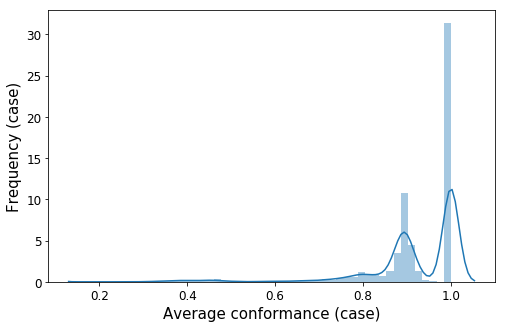

In [76]:
grouped = test_df.groupby(['fold_no', 'caseid']).agg({
    'finalconf': np.mean
}).reset_index()

fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(grouped['finalconf'], ax=ax)

ax.set_xlabel('Average conformance (case)', fontsize=15)
ax.set_ylabel('Frequency (case)', fontsize=15)

for item in ax.get_xticklabels():
    item.set_fontsize(12)
for item in ax.get_yticklabels():
    item.set_fontsize(12)
    
out_fp = os.path.join('imgs', 'src', 'conformance-distplot.svg')
fig.savefig(out_fp, bbox_inches='tight')

### Identifying points of non-conformance

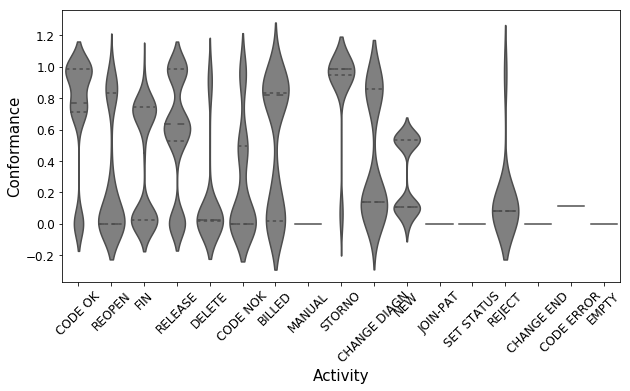

In [128]:
xlabel = 'activity'
ylabel = 'finalconf'

conforming = test_df['finalconf'] >= 0.99
df = test_df.loc[~conforming,:]

fig, ax = plt.subplots(figsize=(10, 5))
clrs = ['grey' for x in df[xlabel].unique()]
ax = sns.violinplot(x=xlabel, y=ylabel, data=df,
                   palette=clrs, scale='width', inner='quartile')
ax.set_xlabel('Activity', fontsize=15)
ax.set_ylabel('Conformance', fontsize=15)

for item in ax.get_xticklabels():
    item.set_rotation(45)
    item.set_fontsize(12)
    
for item in ax.get_yticklabels():
    item.set_fontsize(12)
    
out_fp = os.path.join('imgs', 'src', 'violinplot-activity-conformance.svg')
fig.savefig(out_fp, bbox_inches='tight')

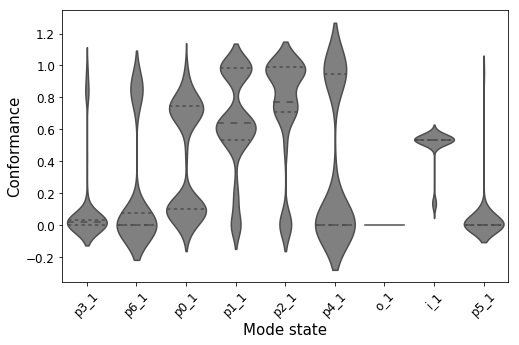

In [129]:
xlabel = 'mode_state'
ylabel = 'finalconf'

conforming = test_df['finalconf'] >= 0.99
df = test_df.loc[~conforming,:]

fig, ax = plt.subplots(figsize=(8, 5))
clrs = ['grey' for x in df[xlabel].unique()]
ax = sns.violinplot(x=xlabel, y=ylabel, data=df,
                   palette=clrs, scale='width', inner='quartile')
ax.set_xlabel('Mode state', fontsize=15)
ax.set_ylabel('Conformance', fontsize=15)

for item in ax.get_xticklabels():
    item.set_rotation(45)
    item.set_fontsize(12)
    
for item in ax.get_yticklabels():
    item.set_fontsize(12)
    
out_fp = os.path.join('imgs', 'src', 'violinplot-state-conformance.svg')
fig.savefig(out_fp, bbox_inches='tight')

In [136]:
filtered = test_df.groupby(['caseid']).tail(n=1)
has_manual = filtered['case_prefix'].str.contains('JOIN-PAT')
filtered.loc[has_manual, 'case_prefix'].values

array(['NEW;NEW;CHANGE DIAGN;JOIN-PAT;JOIN-PAT;JOIN-PAT;JOIN-PAT;FIN;FIN;RELEASE;RELEASE;CODE OK;BILLED;BILLED',
       'NEW;NEW;CHANGE DIAGN;JOIN-PAT;JOIN-PAT;JOIN-PAT;FIN;FIN;RELEASE;RELEASE;CODE OK;BILLED;BILLED',
       'NEW;NEW;CHANGE DIAGN;CHANGE DIAGN;FIN;FIN;RELEASE;RELEASE;CODE OK;BILLED;BILLED;STORNO;STORNO;REJECT;REJECT;BILLED;BILLED;STORNO;STORNO;REJECT;REJECT;BILLED;BILLED;STORNO;STORNO;REJECT;REJECT;JOIN-PAT;JOIN-PAT;JOIN-PAT;JOIN-PAT;BILLED;BILLED',
       'NEW;NEW;CHANGE DIAGN;JOIN-PAT;JOIN-PAT;JOIN-PAT;JOIN-PAT;FIN;FIN;RELEASE;RELEASE;CODE OK;REOPEN;REOPEN;DELETE;DELETE',
       'NEW;NEW;CHANGE DIAGN;FIN;FIN;RELEASE;RELEASE;CODE OK;JOIN-PAT;JOIN-PAT;JOIN-PAT;JOIN-PAT;BILLED;BILLED',
       'NEW;NEW;CHANGE DIAGN;JOIN-PAT;JOIN-PAT;JOIN-PAT;JOIN-PAT;FIN;FIN;RELEASE;RELEASE;CODE OK;BILLED;BILLED;STORNO;STORNO;BILLED;BILLED',
       'NEW;NEW;CHANGE DIAGN;JOIN-PAT;JOIN-PAT;JOIN-PAT;JOIN-PAT;FIN;FIN;RELEASE;RELEASE;CODE OK;BILLED;BILLED',
       'NEW;NEW;CHANGE DIAGN;JOIN-PAT